In [1]:
# Colab Setup (Run this first)

In [2]:
!pip install litebird_sim rich

# `litebird_sim` example notebook


To run this notebook, you have several options:

-   If you are running this under Binder, you should already be set!
-   If you are running this under Google Colab, be sure to run the cell with `!pip install…` that is right above the title.
-   If you are running this locally, you should first create and activate a new virtual environment with the commands

    ```
    python -m venv ./my_venv
    source ./my_venv/bin/activate
    ```

    (you can use Conda environments, if you prefer) and install Jupyter and litebird_sim in it:

    ```
    pip install jupyter litebird_sim
    ```

    If you have a local copy of the `litebird_sim` repository cloned from <https://github.com/litebird/litebird_sim> (e.g., because you're part of the Simulation Team!), you can use a _development install_ instead:

    ```
    cd /my/local/copy/litebird_sim
    pip install -e .
    ```


## Set up the environment


In [3]:
# Using this file, we can use "import litebird_sim" even if it is not installed system-wide

We start by importing a few libraries that will be useful in this notebook.


In [4]:
import litebird_sim as lbs
import numpy as np
import matplotlib.pylab as plt
from healpy import mollview
import astropy
import astropy.time

%matplotlib inline

In [5]:
lbs.PTEP_IMO_LOCATION

PosixPath('/Users/luca/Documents/Universita/litebird/simteam/codes/litebird_sim/litebird_sim/default_imo/schema.json.gz')

## Parameters of the simulation

We will simulate a pair of 140 GHz LFT detectors. Their definition will be taken from the LiteBIRD Instrument MOdel (IMO) version vPTEP (**new!**), and we will simulate 1 year of observation. See the [documentation](https://litebird-sim.readthedocs.io/en/latest/simulations.html#simulations) for more details about the input parameters.


In [6]:
telescope = "LFT"
channel = "L4-140"
detlist = ["000_001_017_QB_140_T", "000_001_017_QB_140_B"]

start_time = astropy.time.Time("2025-01-01T00:00:00")
mission_time_days = 365

imo_version = "vPTEP"

# Resolution of the output maps
nside = 64

To use the IMO bundled in `litebird_sim`, one needs to do the following:


In [7]:
# This is the folder where the final report with the results of the simulation will be saved
base_path = ".test"

imo = lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)

# initializing the simulation
sim = lbs.Simulation(
    base_path=base_path,
    imo=imo,
    # mpi_comm=comm,  <--- needed if parallelizing
    start_time=start_time,
    duration_s=mission_time_days * 24 * 3600.0,
    random_seed=12345,  # seed for the random number generator (MANDATORY parameter!!!)
)

Otherwise, if you want to install the IMO, follow the instructions [in the IMO documentation](https://litebird-sim.readthedocs.io/en/master/imo.html#configuring-the-imo). You can install the IMO with the command `python -m litebird_sim.install_imo` with the [schema.json](https://github.com/litebird/litebird_sim/tree/master/default_imo) in `litebird_sim` or with any other local copy. In this case, use the following:


In [8]:
# This is the folder where the final report with the results of the simulation will be saved
base_path = ".test"

# This loads the full IMO (not only the version specified by `imo_version`!)
imo = lbs.Imo()

# initializing the simulation
sim = lbs.Simulation(
    base_path=base_path,
    # mpi_comm=comm,  <--- needed if parallelizing
    start_time=start_time,
    duration_s=mission_time_days * 24 * 3600.0,
    random_seed=12345,  # seed for the random number generator (MANDATORY parameter!!!)
)

The following instructions load from the IMO the information about the [instrument](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) and the [detectors](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) used in the simulation.


In [ ]:
# Load the definition of the instrument (MFT)
sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
    )
)

# filling dets with info and detquats with quaternions of the detectors in detlist
dets: list[lbs.DetectorInfo] = []
for n_det in detlist:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )

    # we overwrite the nominal sampling rate read from IMO with a smaller one, so that
    # we produce 12 months tod without taking too much memory
    det.sampling_rate_hz = 2

    dets.append(det)

# otherwise sim.set_detectors() stores in sim.detectors the detectors read from IMO
sim.set_detectors(
    channels=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
    detectors=detlist,
)

[DetectorInfo(name='000_001_017_QB_140_T', wafer='L01', pixel=17, pixtype='LP4', channel='L4-140', squid=None, sampling_rate_hz=31.0, fwhm_arcmin=23.7, ellipticity=1.0, psi_rad=0.0, bandcenter_ghz=140.0, bandwidth_ghz=42.0, band_freqs_ghz=array([ 98.        ,  98.66141732,  99.32283465,  99.98425197,
        100.64566929, 101.30708661, 101.96850394, 102.62992126,
        103.29133858, 103.95275591, 104.61417323, 105.27559055,
        105.93700787, 106.5984252 , 107.25984252, 107.92125984,
        108.58267717, 109.24409449, 109.90551181, 110.56692913,
        111.22834646, 111.88976378, 112.5511811 , 113.21259843,
        113.87401575, 114.53543307, 115.19685039, 115.85826772,
        116.51968504, 117.18110236, 117.84251969, 118.50393701,
        119.16535433, 119.82677165, 120.48818898, 121.1496063 ,
        121.81102362, 122.47244094, 123.13385827, 123.79527559,
        124.45669291, 125.11811024, 125.77952756, 126.44094488,
        127.1023622 , 127.76377953, 128.42519685, 129.0866

The following command will take some time: it needs to compute the ephemerides of the Earth with respect to the Ecliptic reference frame and derive the orientation of the LFT instrument as a function of time for the whole duration of the simulation. This step will be needed later, when we will obtain the pointings for the detectors involved in the simulation. See the [documentation](https://litebird-sim.readthedocs.io/en/latest/scanning.html#scanning-strategy) for more details about the scanning strategy.


In [10]:
# Generate the quaternions describing how the instrument moves in the Ecliptic reference frame
sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

## Initialize TODs, generate inputs, and fill TODs with them


Let's now create a set of «[observations](https://litebird-sim.readthedocs.io/en/latest/observations.html#observations)». This concept was mutuated by [TOAST](https://github.com/hpc4cmb/toast), and it represents a chunk of data acquired while the instrument was in almost stable conditions (i.e., stationary noise, no thermal drifts…). For the sake of simplicity, we create just _one_ observation, but of course in realistic simulations you will have several observations spread among the available MPI processes.


In [ ]:
# creating one observation
sim.create_observations(
    detectors=dets,  # overwrite the list of detectors to be used in the observation, and originally set with sim.set_detectors
    n_blocks_det=1,
    n_blocks_time=1,  # blocks different from one if parallelizing
)

assert len(sim.observations) == 1

[2026-01-26 10:22:51,756 WARNING MPI#0000] **Warning**: `Simulation.detectors` was already populated but has been overwritten by a manual list passed to `create_observations`.


TODs are not enough to produce maps, as we need _pointing information_ too: this is the direction and orientation of each receiver as a function of time.

So, here comes the part where we need to simulate the pointings. Much of the work has already been done, as the ephemerides were already computed in the call to `sim.set_scanning_strategy` (see above). Now, we teach each observation in the simulation how to compute its pointings. 

In [12]:
sim.set_hwp(
    lbs.IdealHWP(
        getattr(sim.instrument, "hwp_rpm") * 2 * np.pi / 60,
    ),  # sets the hwp
)
sim.prepare_pointings()

Now we know where the detectors are looking at. Let's produce a synthetic image of the sky at the frequencies sampled by the two detectors we're simulating; for this, we need the information about the [frequency channel](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) we are simulating (140 GHz), so we retrieve them from the IMO again:


In [13]:
# loading channel info
ch_info = []
ch_info.append(
    lbs.FreqChannelInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
        imo=imo,
    )
)

The LiteBIRD Simulation Framework provides [SkyGenerator](https://litebird-sim.readthedocs.io/en/latest/input_sky.html), which is a wrapper to PySM; we use it to produce a map of the sky including synchrotron, free-free, and dust, and we smooth the map according to the FWHM specified in the IMO. (Note that we do not need to pass this information explicitly, as SkyGenerator is able to extract it from `ch_info`.)


In [14]:
# let's make an input CMB+foreground map

# this sets the parameters for the generation of the map
sky_params = lbs.SkyGenerationParams(
    make_cmb=True,
    make_fg=True,
    fg_models=["s0", "f1", "d0"],  # set the FG models you want
    seed_cmb=1,  # set this seed if you want to fix the CMB realization
    apply_beam=True,  # if True, smooths the input map by the beam of the channel
    bandpass_integration=False,  # if True, integrates over the top-hat bandpass of the channel
    units="K_CMB",
    output_type="map",
    nside=nside,
)

sky = sim.get_sky(parameters=sky_params, channels=ch_info, store_in_observation=True)

[2026-01-26 10:22:51,974 INFO MPI#0000] Generating CMB...
[2026-01-26 10:22:51,994 INFO MPI#0000] Generating Foregrounds...
[2026-01-26 10:22:51,995 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2026-01-26 10:22:51,996 INFO MPI#0000] NSIDE = 512
[2026-01-26 10:22:51,997 INFO MPI#0000] ORDERING = RING in fits file
[2026-01-26 10:22:51,997 INFO MPI#0000] INDXSCHM = IMPLICIT
[2026-01-26 10:22:52,052 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2026-01-26 10:22:52,053 INFO MPI#0000] NSIDE = 512
[2026-01-26 10:22:52,053 INFO MPI#0000] ORDERING = RING in fits file
[2026-01-26 10:22:52,054 INFO MPI#0000] INDXSCHM = IMPLICIT
[2026-01-26 10:22:52,101 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2026-01-26 10:22:52,103 INFO MPI#0000] NSIDE = 512
[2026-01-26 10:22:52,103 INFO MPI#0000] ORDERING = RING in fits file
[2026-01-26 10:22:52,103 INFO MPI#0000] INDXSCHM = IMPLICIT
[2026-01-26 10:

In [15]:
# sky is a dictionary that contains maps per channel simulated, the coordiante system used and the parameters used in the SkyGenerator call
sky

{'L4-140': HealpixMap(values=array([[-2.88255644e-07,  1.11731345e-04,  1.22100035e-04, ...,
          7.00143282e-06,  7.42816723e-05, -4.94974957e-05],
        [ 5.16637310e-08, -1.28217453e-06,  2.43960823e-07, ...,
          5.62095859e-08, -1.77773773e-07,  3.22125758e-07],
        [ 5.80236105e-07, -3.42395543e-07,  2.80442492e-07, ...,
          7.94544524e-07,  1.24136342e-06, -1.89787927e-06]]), nside=64, units=<Units.K_CMB: 'K_CMB'>, coordinates=<CoordinateSystem.Galactic: 2>, nest=False, nstokes=3),
 'SkyGenerationParams': SkyGenerationParams(nside=64, lmax=191, output_type='map', units=<Units.K_CMB: 'K_CMB'>, apply_beam=True, apply_pixel_window=False, bandpass_integration=False, nthreads=0, make_cmb=True, make_fg=True, make_dipole=False, return_components=False, cmb_ps_file=None, seed_cmb=1, cmb_r=0.0, fg_models=['s0', 'f1', 'd0'], fg_oversampling=2, sun_velocity_kms=369.816, sun_direction_galactic=(0.842173724, 4.6080357444))}

It's time to simulate the observation of the map by the two receivers. This is done by the function `fill_tods` (see the [documentation](https://litebird-sim.readthedocs.io/en/latest/timeordered.html#filling-tod-with-signal)):

In [16]:
sim.nullify_tod()
sim.fill_tods()

This method adds the sky signal to each `tod` field in the observations in `sim.observations`. These TODs have shape $N_{\rm{det}}$ x $N_{\rm{sample}}$.
The same result can be obtained by the lower level function `lbs.scan_map_in_observations`

In [17]:
getattr(sim.observations[0], "tod").shape

(2, 63072000)

# Map-making

Now that we have a TOD, let's bin it into a map! The LiteBIRD Simulation Framework provides two internal map-makers:

1. A [binner](https://litebird-sim.readthedocs.io/en/latest/mapmaking.html#binner): which simply bins all the observations in a map;

2. A [destriper](https://litebird-sim.readthedocs.io/en/latest/mapmaking.html#destriper): useful when there is 1/f noise in the timelines.

And the interface with two external map-makers:

1. [BrahMap](https://github.com/anand-avinash/BrahMap/tree/main): a Generalized Least Squares (GLS) map-mapamker

2. [Madam](https://arxiv.org/abs/0907.0367): implements a destriper algorithm

Let's use here the binner.


In [18]:
binner_results = sim.make_binned_map(
    nside=nside,  # one can set also a different resolution than the input map
    output_coordinate_system=lbs.CoordinateSystem.Galactic,
)
m_cmb_fg = binner_results.binned_map  # this is the map coming from the binned map-maker

Now that we have produced the binned map, we can compare it with the input map produced by PySM. Here is the map we have just produced:


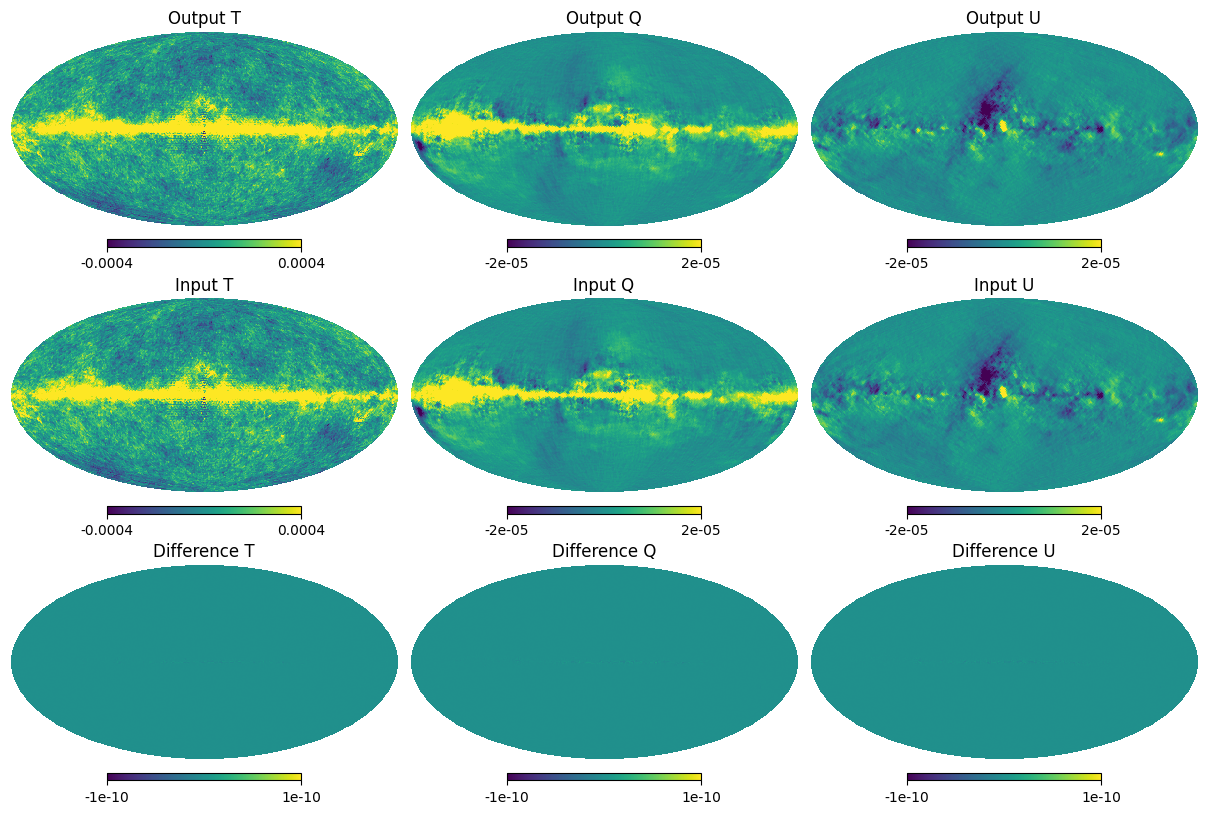

In [19]:
plt.figure(figsize=(12.0, 8.0))

mollview(m_cmb_fg[0], title="Output T", sub=331, min=-4e-4, max=4e-4)
mollview(m_cmb_fg[1], title="Output Q", sub=332, min=-2e-5, max=2e-5)
mollview(m_cmb_fg[2], title="Output U", sub=333, min=-2e-5, max=2e-5)

mollview(sky[channel].values[0], title="Input T", sub=334, min=-4e-4, max=4e-4)
mollview(sky[channel].values[1], title="Input Q", sub=335, min=-2e-5, max=2e-5)
mollview(sky[channel].values[2], title="Input U", sub=336, min=-2e-5, max=2e-5)

mollview(
    m_cmb_fg[0] - sky[channel].values[0],
    title="Difference T",
    sub=337,
    min=-1e-10,
    max=1e-10,
)
mollview(
    m_cmb_fg[1] - sky[channel].values[1],
    title="Difference Q",
    sub=338,
    min=-1e-10,
    max=1e-10,
)
mollview(
    m_cmb_fg[2] - sky[channel].values[2],
    title="Difference U",
    sub=339,
    min=-1e-10,
    max=1e-10,
)

## Add noise

Let's add [white noise](https://litebird-sim.readthedocs.io/en/latest/timeordered.html#adding-noise) to the CMB+FG TOD


In [20]:
sim.add_noise(noise_type="white")

Also in this case the function `sim.add_noise(noise_type = 'one_over_f', random = sim.random)` is a wrapper to `lbs.add_noise_to_observations`


Let's do the maps

In [21]:
binner_results = sim.make_binned_map(
    nside=nside,  # one can set also a different resolution than the input map
    output_coordinate_system=lbs.CoordinateSystem.Galactic,
)
m_cmb_fg = binner_results.binned_map  # this is the map coming from the binned map-maker
m_cmb_fg_cov = (
    binner_results.invnpp
)  # inverse of the covariance matrix element for each pixel in the map.

Let's plot them

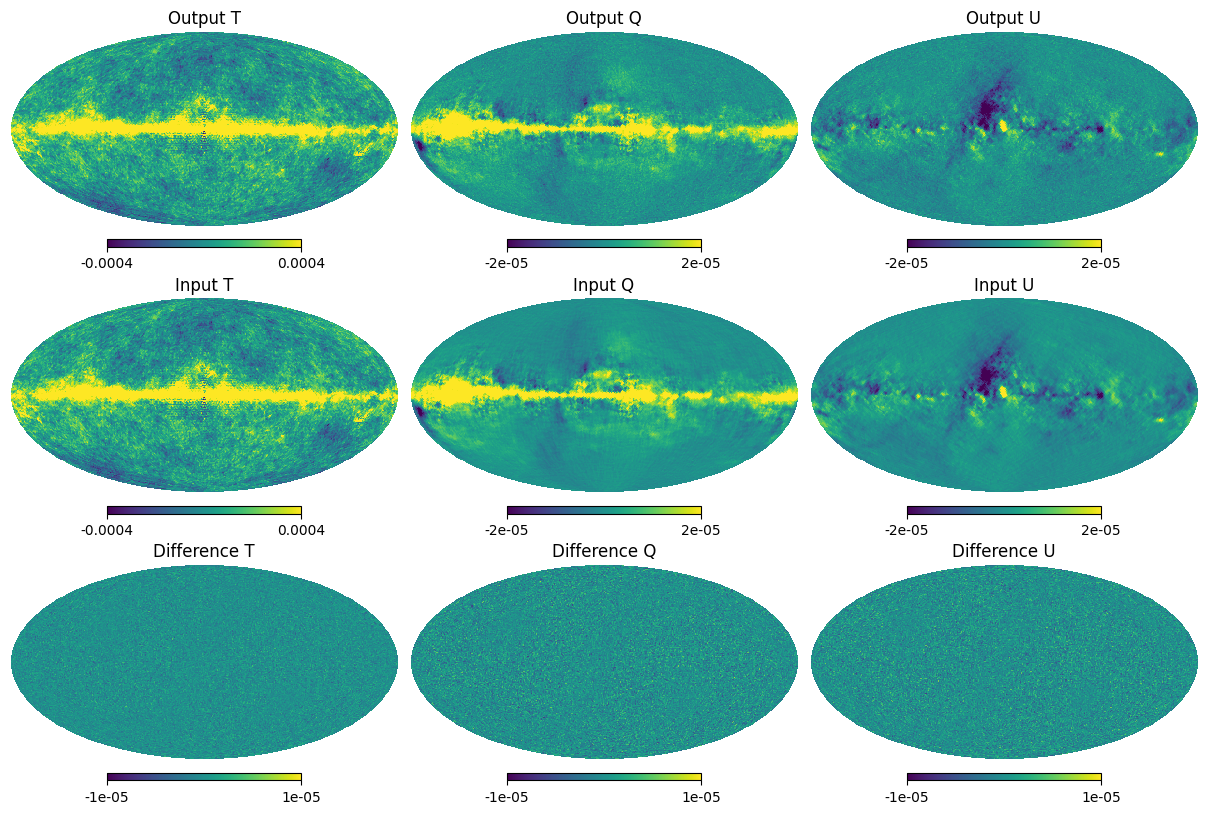

In [22]:
plt.figure(figsize=(12.0, 8.0))

mollview(m_cmb_fg[0], title="Output T", sub=331, min=-4e-4, max=4e-4)
mollview(m_cmb_fg[1], title="Output Q", sub=332, min=-2e-5, max=2e-5)
mollview(m_cmb_fg[2], title="Output U", sub=333, min=-2e-5, max=2e-5)

mollview(sky[channel].values[0], title="Input T", sub=334, min=-4e-4, max=4e-4)
mollview(sky[channel].values[1], title="Input Q", sub=335, min=-2e-5, max=2e-5)
mollview(sky[channel].values[2], title="Input U", sub=336, min=-2e-5, max=2e-5)

mollview(
    m_cmb_fg[0] - sky[channel].values[0],
    title="Difference T",
    sub=337,
    min=-1e-5,
    max=1e-5,
)
mollview(
    m_cmb_fg[1] - sky[channel].values[1],
    title="Difference Q",
    sub=338,
    min=-1e-5,
    max=1e-5,
)
mollview(
    m_cmb_fg[2] - sky[channel].values[2],
    title="Difference U",
    sub=339,
    min=-1e-5,
    max=1e-5,
)

The noise covariance matrix for each pixel is $\sigma^2 \left(A^T A\right)^{-1}$, where $A$ is the pointing matrix, with dimensions $N_{\rm{samples}} × \left(3 × N_{\rm{pixels}} \right)$ and $\sigma$ is in $\mu$K

$\left(A^T A\right)$ represents how many times the pixel has been visited, so $\sigma^2 \left(A^T A\right)^{-1}$ represents the noise of the pixel weighted by the times it has been observed


In [23]:
# the cov map has shape npix×3×3
m_cmb_fg_cov.shape

(49152, 3, 3)

Let's plot tthe covariance

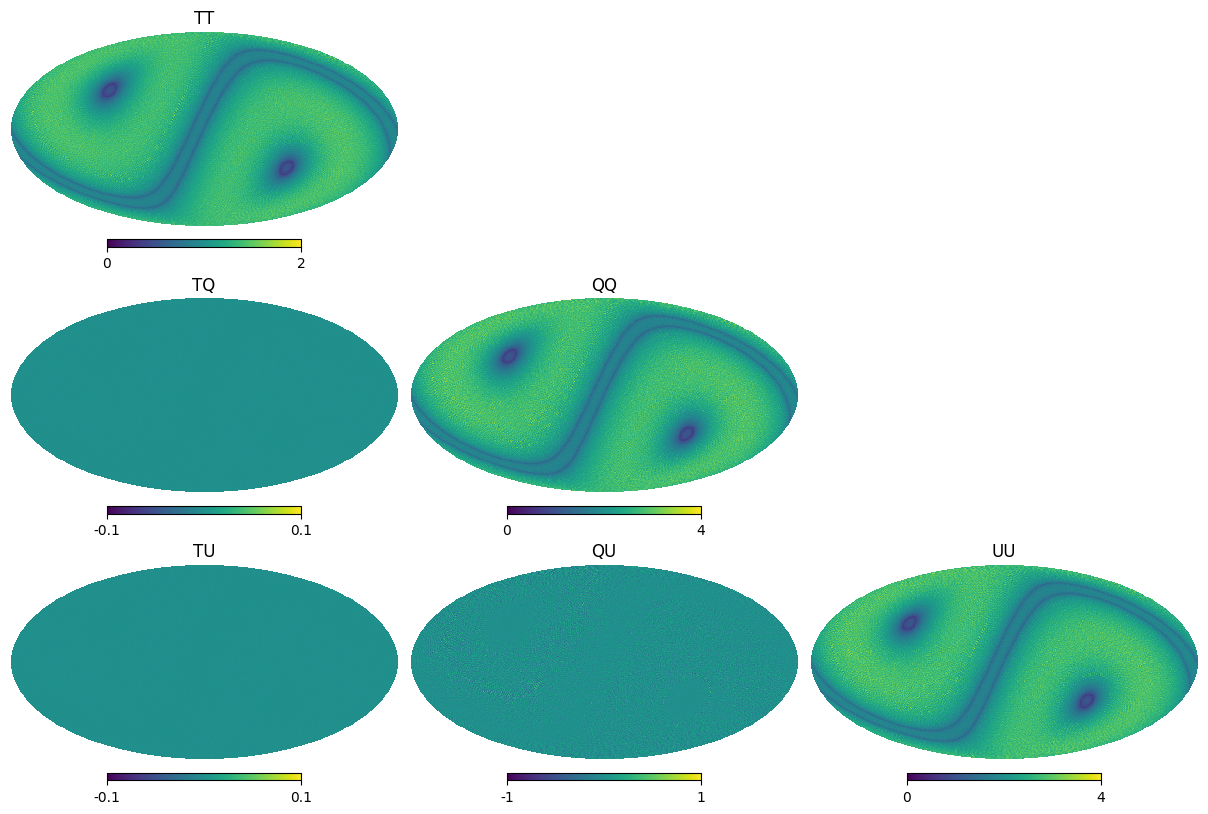

In [24]:
plt.figure(figsize=(12.0, 8.0))

mollview(m_cmb_fg_cov[:, 0, 0], title="TT", sub=331, min=0, max=2)

mollview(m_cmb_fg_cov[:, 0, 1], title="TQ", sub=334, min=-1e-1, max=1e-1)
mollview(m_cmb_fg_cov[:, 1, 1], title="QQ", sub=335, min=0, max=4)

mollview(m_cmb_fg_cov[:, 0, 1], title="TU", sub=337, min=-1e-1, max=1e-1)
mollview(m_cmb_fg_cov[:, 1, 2], title="QU", sub=338, min=-1, max=1)
mollview(m_cmb_fg_cov[:, 2, 2], title="UU", sub=339, min=0, max=4)